In [1]:
# Cell 1: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, 
                             f1_score, precision_recall_curve, auc)
import xgboost as xgb
import joblib

# Set random seeds for reproducibility
np.random.seed(42)

print("Loading and preparing data...")

# Load the synthetic dataset
df = pd.read_csv('synthetic_churn_data.csv')

# Display basic dataset info
print(f"Dataset shape: {df.shape}")
print(f"Churn distribution:\n{df['churn'].value_counts()}")
print(f"Churn rate: {df['churn'].mean():.2%}")

df.head()

Loading and preparing data...
Dataset shape: (10000, 12)
Churn distribution:
churn
0    7500
1    2500
Name: count, dtype: int64
Churn rate: 25.00%


,customer_id,tenure,age,support_calls,subscription_type,country,monthly_usage,avg_session_duration,feature_1_usage,feature_2_usage,churn,usage_intensity
0,1,52,75,0,Basic,UK,32.374618,16.473425,1.157110,6.040795,0,0.622589
1,2,15,37,1,Premium,France,19.353461,31.269014,2.707515,1.549471,0,1.290231
2,3,61,53,1,Enterprise,UK,30.092976,78.577621,4.528766,12.918040,0,0.493327
3,4,21,65,0,Basic,France,32.243516,10.020259,0.949944,0.051125,0,1.535406
4,5,24,21,0,Premium,UK,20.240402,30.901430,0.383702,2.025493,0,0.843350


In [2]:
# Cell 2: Feature Engineering
print("Performing feature engineering...")

# Create copy of dataframe for modeling
model_df = df.copy()

# Convert categorical variables to numeric using one-hot encoding
categorical_cols = ['subscription_type', 'country']
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# Create additional features that might be predictive
model_df['support_intensity'] = model_df['support_calls'] / model_df['tenure'].clip(1)
model_df['total_usage'] = model_df['monthly_usage'] * model_df['tenure']
model_df['engagement_score'] = model_df['avg_session_duration'] * model_df['monthly_usage']

# Separate features and target
X = model_df.drop(['customer_id', 'churn'], axis=1)
y = model_df['churn']

# Split data into train and test sets (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Features: {list(X.columns)}")

Performing feature engineering...
Training set: (7000, 17), Test set: (3000, 17)
Features: ['tenure', 'age', 'support_calls', 'monthly_usage', 'avg_session_duration', 'feature_1_usage', 'feature_2_usage', 'usage_intensity', 'subscription_type_Enterprise', 'subscription_type_Premium', 'country_Germany', 'country_India', 'country_UK', 'country_USA', 'support_intensity', 'total_usage', 'engagement_score']


In [3]:
# Cell 3: Train XGBoost Model (SIMPLEST version)
print("Training XGBoost model with good default parameters...")

# Using good default parameters for binary classification
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Simple fit without early stopping (works on all versions)
model.fit(X_train, y_train)

print("Model training complete!")

# Check XGBoost version for reference
import xgboost as xgb
print(f"XGBoost version: {xgb.__version__}")

Training XGBoost model with good default parameters...
Model training complete!
XGBoost version: 3.0.3


In [4]:
# Cell 4: Model Evaluation
print("Evaluating model performance...")

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print("=== Model Performance ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Evaluating model performance...
=== Model Performance ===
Accuracy: 0.9727
ROC-AUC: 0.9960
F1-Score: 0.9448

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2250
           1       0.95      0.94      0.94       750

    accuracy                           0.97      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



Generating evaluation visualizations...


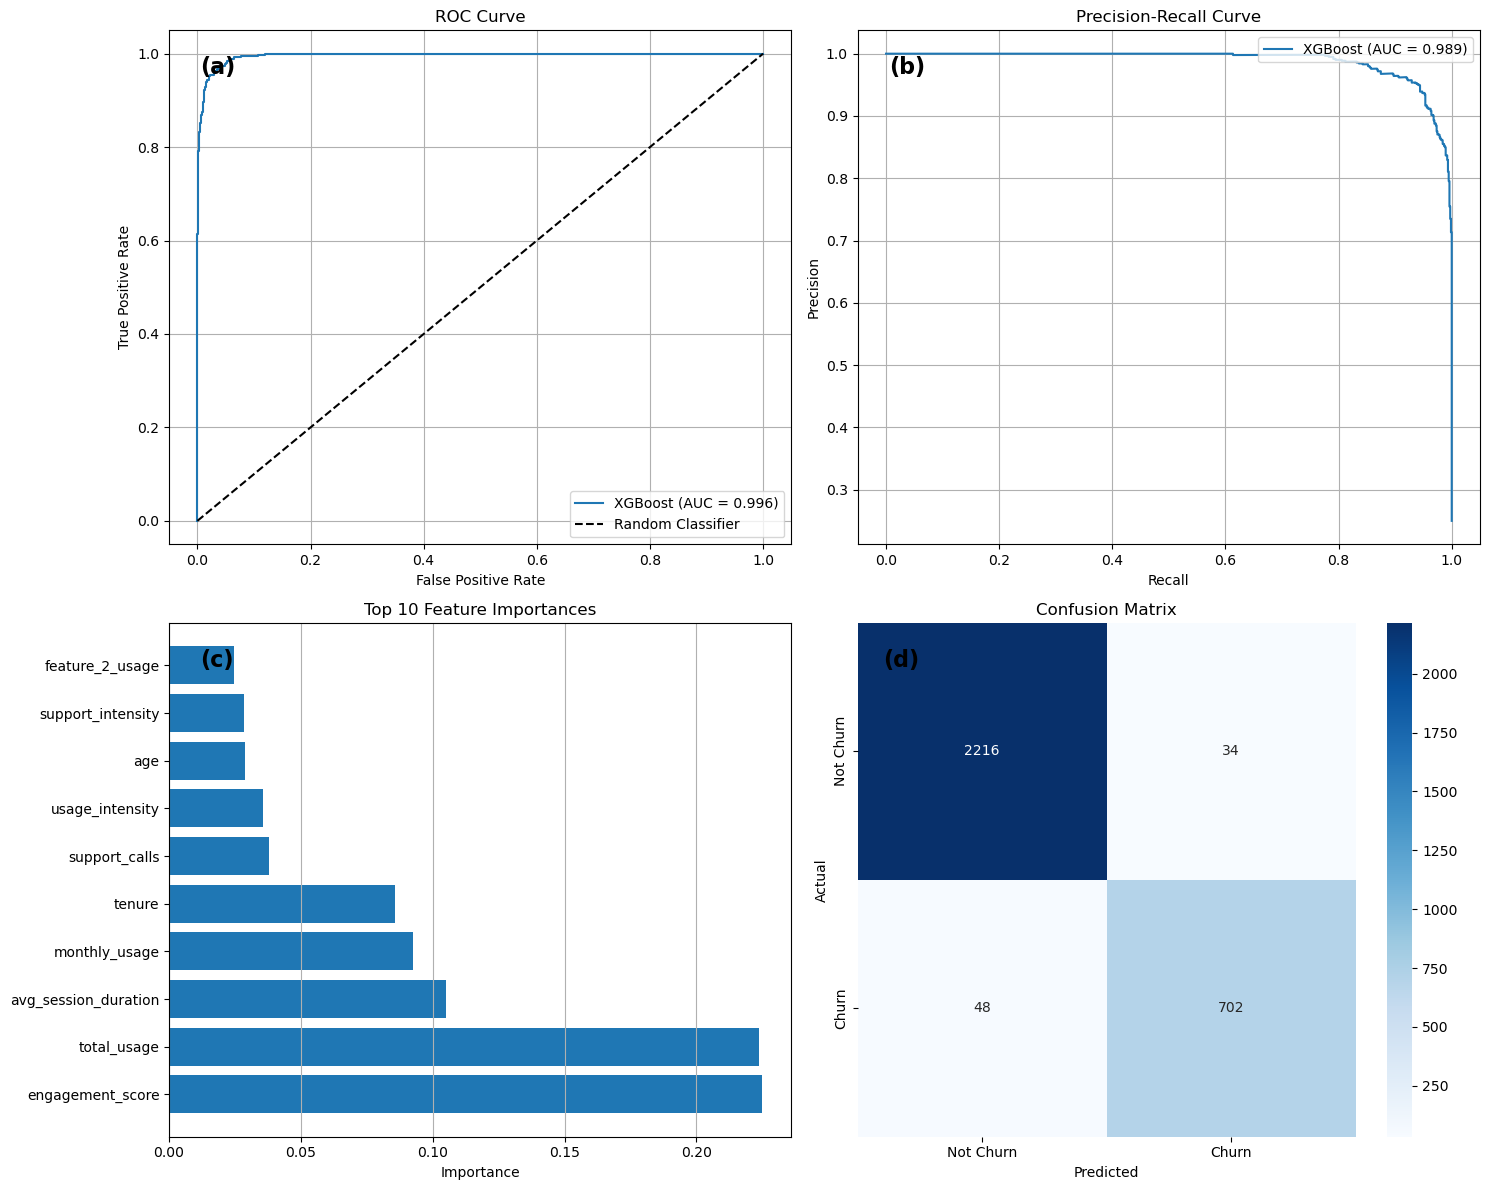

Evaluation plots saved to 'model_evaluation_plots.png'


In [5]:
# Cell 5: Create Visualizations
print("Generating evaluation visualizations...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# --- NEW CODE: ADD THIS BLOCK RIGHT HERE ---
# Add (a), (b), (c), (d) labels to each subplot
ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')
ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
ax3.text(0.05, 0.95, '(c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')
ax4.text(0.05, 0.95, '(d)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top')
# -------------------------------------------

# ROC Curve (Now will be labeled (a))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax1.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')
ax1.grid(True)

# Precision-Recall Curve (Now will be labeled (b))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, label=f'XGBoost (AUC = {pr_auc:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='upper right')
ax2.grid(True)

# Feature Importance (Now will be labeled (c))
feature_importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False).head(10)

ax3.barh(importance_df['feature'], importance_df['importance'])
ax3.set_xlabel('Importance')
ax3.set_title('Top 10 Feature Importances')
ax3.grid(True, axis='x')

# Confusion Matrix Heatmap (Now will be labeled (d))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Evaluation plots saved to 'model_evaluation_plots.png'")

In [8]:
# Get the TRUE feature importance values from your model
feature_importance = model.feature_importances_
feature_names = X.columns

# Create a DataFrame and sort it
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

# Display the TOP 10 features with their TRUE importance values
print("Top 10 Features by TRUE Importance:")
print(importance_df.head(10))

Top 10 Features by TRUE Importance:
                 feature  importance
16      engagement_score    0.224809
15           total_usage    0.223889
4   avg_session_duration    0.104951
3          monthly_usage    0.092647
0                 tenure    0.085876
2          support_calls    0.037814
7        usage_intensity    0.035792
1                    age    0.028679
14     support_intensity    0.028594
6        feature_2_usage    0.024537


In [6]:
# Cell 6: Save Model and Features
# Save the trained model
model_filename = 'churn_prediction_model.pkl'
joblib.dump(model, model_filename)
print(f"Trained model saved to '{model_filename}'")

# Save the feature names for later use in the dashboard
feature_names = list(X.columns)
joblib.dump(feature_names, 'feature_names.pkl')
print("Feature names saved to 'feature_names.pkl'")

print("\nModel training and evaluation complete!")

Trained model saved to 'churn_prediction_model.pkl'
Feature names saved to 'feature_names.pkl'

Model training and evaluation complete!


In [7]:
# Cell 7: Test the Model on Sample Data (Optional)
print("Testing model on sample data...")

# Get a few samples from the test set
sample_data = X_test.head(3)
sample_true_labels = y_test.head(3).values

# Make predictions
sample_predictions = model.predict(sample_data)
sample_probabilities = model.predict_proba(sample_data)[:, 1]

print("Sample predictions:")
for i, (true_label, pred, prob) in enumerate(zip(sample_true_labels, sample_predictions, sample_probabilities)):
    print(f"Sample {i+1}: True={true_label}, Predicted={pred}, Probability={prob:.3f}")

Testing model on sample data...
Sample predictions:
Sample 1: True=1, Predicted=1, Probability=0.999
Sample 2: True=0, Predicted=0, Probability=0.000
Sample 3: True=0, Predicted=0, Probability=0.000
